<a href="https://colab.research.google.com/github/EmaadKhwaja/Deep-Learning-Denoising/blob/master/Putzky%20Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
BATCH_SIZE=50
CROP_SIZE=300

TRAIN_DATA_PATH = "drive/My Drive/Research/Graduate School/Bo Huang Rotation/Deep-Learning-Denoising-master/Confocal_BPAE_B/raw"
GT_DATA_PATH = "drive/My Drive/Research/Graduate School/Bo Huang Rotation/Deep-Learning-Denoising-master/Confocal_BPAE_B/gt"
NOISE_WEIGHT = 1

VALIDATION_PCT = .2
RANDOM_SEED = 42
SHUFFLE_DATASET = True

MAX_T=10
EPOCHS=1

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
sys.path.append("drive/My Drive/Research/Graduate School/Bo Huang Rotation/Deep-Learning-Denoising-master")

from IPython.display import clear_output
%matplotlib inline

import logging
import numpy as np
from numpy import inf
from skimage.metrics import structural_similarity as ssm
from scipy.special import factorial
from matplotlib import pyplot as plt


import torch
import torch.utils.data as data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SequentialSampler
import torch.nn as nn
from torch.nn import MSELoss
from torch.autograd import Variable
from torch.optim import Adam
import torch.nn.functional as f
from torch.autograd import Variable



import torchvision
from torchvision import transforms



from util import show, plot_images, plot_tensors

In [0]:
class gtmatch():
    def __init__(self, dataset1, dataset2, batch_size):
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        self.batch_size=batch_size

    def __getitem__(self, index):
        x = self.dataset1[index][0]
        y = self.dataset2[int(index / self.batch_size % self.batch_size)][0]
        return x, y

    def __len__(self):
        return len(self.dataset1)
    
  

class log_funcs():
    def __init__(self, updated, noise_ref):
        self.updated=updated
        self.noise_ref=noise_ref

    def poisson_log(Ax, b):
        # from https://stanford.edu/class/ee367/reading/lecture10_notes.pdf
        Ax, b =Ax.detach(), b.detach()
        term1 = np.log(Ax.cpu())*b.cpu()
        term2 = Ax.cpu()
        term3 = torch.from_numpy(np.log(factorial(b.cpu())))
        
        loglikelihood = term1 - term2 - term3
        loglikelihood[np.isnan(loglikelihood)==True]=-10000000
        loglikelihood[np.isinf(loglikelihood)==True]=-10000000
        return loglikelihood[0]
    
    def gradient(updated, noise_ref):
        grad_ll = []
        zero_matrix = torch.zeros([noise_ref.shape[2], noise_ref.shape[3]], dtype=torch.double)
        
        ll_sum=zero_matrix.detach()
        llh_sum=zero_matrix.detach()

        for i, Ax in enumerate(noise_ref):
            b = updated[i]
            b_plus = updated[i]+.0001
            
            # Poisson log-likelihood
            loglikelihood = log_funcs.poisson_log(Ax, b)
            loglikelihood_plus = log_funcs.poisson_log(Ax, b_plus)

        
            grad=(loglikelihood_plus-loglikelihood)/.0001
            grad_ll.append(grad)
            
        return torch.stack(grad_ll).unsqueeze(1).float()


        
def add_noise(clean_images,noise_weight,noise_type):
    clean_np = np.clip(clean_images.detach().cpu().numpy(),0,1)

    if 'Poisson' in noise_type:
        noise_mask = np.random.poisson(clean_np)
    else:
        noise_mask= clean_np*0

    noisy_images = torch.clamp(torch.from_numpy(clean_np+(noise_mask*noise_weight)),0,1).float() 
    return noisy_images


def live_plot(data, figsize=(7,5), title=''):
    plt.figure(figsize=figsize)
    plt.plot(data)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('Iteration')
    clear_output(wait=True)
    plt.show();

In [0]:
import torch
import torch.nn as nn

class InputRNN(torch.nn.Module):

    def __init__(self, rnn_cell=None, input_fun=None):
        super(InputRNN, self).__init__()

        self.rnn_cell = rnn_cell
        self.input_fun = input_fun

    def forward(self, x, hx=None):

        if self.input_fun is not None:
            x = self.input_fun.forward(x)
        if self.rnn_cell is not None:
            x = self.rnn_cell.forward(x)
            hx = x

        return x, hx

class ConvNonlinear(nn.Module):

    def __init__(self, input_size, features, conv_dim, kernel_size, dilation, bias, nonlinear='relu'):
        super(ConvNonlinear, self).__init__()

        self.input_size = input_size
        self.features = features
        self.bias = bias
        self.conv_dim = conv_dim
        self.conv_class = self.determine_conv_class(conv_dim)
        if nonlinear is not None and nonlinear.upper() == 'RELU':
            self.nonlinear = torch.nn.ReLU()
        elif nonlinear is None:
            self.nonlinear = lambda x: x
        else:
            ValueError('Please specify a proper')

        self.padding = [torch.nn.ReplicationPad1d(dilation * (kernel_size-1) // 2),
                        torch.nn.ReplicationPad2d(dilation * (kernel_size-1) // 2),
                        torch.nn.ReplicationPad3d(dilation * (kernel_size - 1) // 2)][conv_dim-1]
        self.conv_layer =  self.conv_class(in_channels=input_size, out_channels=features,
                             kernel_size=kernel_size, padding=0,
                             dilation=dilation, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_normal_(self.conv_layer.weight, nonlinearity='relu')

        if self.conv_layer.bias is not None:
            nn.init.zeros_(self.conv_layer.bias)

    def determine_conv_class(self, n_dim):

        if n_dim is 1:
            return nn.Conv1d
        elif n_dim is 2:
            return nn.Conv2d
        elif n_dim is 3:
            return nn.Conv3d
        else:
            NotImplementedError("No convolution of this dimensionality implemented")

    def extra_repr(self):
        s = '{input_size}, {features}'
        if 'bias' in self.__dict__ and self.bias is not True:
            s += ', bias={bias}'
        if 'nonlinear' in self.__dict__ and self.nonlinear != "tanh":
            s += ', nonlinearity={nonlinear}'
        return s.format(**self.__dict__)

    def check_forward_input(self, input):
        if input.size(1) != self.input_size:
            raise RuntimeError(
                "input has inconsistent input_size: got {}, expected {}".format(
                    input.size(1), self.input_size))

    def forward(self, input):
        return self.nonlinear(self.conv_layer(self.padding(input)))


class ConvRNNCellBase(nn.Module):

    def __init__(self, input_size, hidden_size, num_chunks, conv_dim, kernel_size,
                dilation, bias):
        super(ConvRNNCellBase, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.num_chunks = num_chunks
        self.conv_dim = conv_dim
        self.conv_class = self.determine_conv_class(conv_dim)
        self.ih = self.conv_class(in_channels=input_size, out_channels=num_chunks*hidden_size,
                             kernel_size=kernel_size, padding=dilation * (kernel_size-1)//2,
                             dilation=dilation, bias=bias)
        self.hh = self.conv_class(in_channels=hidden_size, out_channels=num_chunks*hidden_size,
                             kernel_size=kernel_size, padding=dilation * (kernel_size-1)//2,
                             dilation=dilation, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):

        self.ih.weight.data = self.orthotogonalize_weights(self.ih.weight.data)
        self.hh.weight.data = self.orthotogonalize_weights(self.hh.weight.data)

        if self.bias is True:
            nn.init.zeros_(self.ih.bias)
            nn.init.zeros_(self.hh.bias)

    def orthotogonalize_weights(self, weights, chunks=1):
        return torch.cat([nn.init.orthogonal_(w) for w in weights.chunk(chunks,0)],0)

    def determine_conv_class(self, n_dim):

        if n_dim is 1:
            return nn.Conv1d
        elif n_dim is 2:
            return nn.Conv2d
        elif n_dim is 3:
            return nn.Conv3d
        else:
            NotImplementedError("No convolution of this dimensionality implemented")

    def extra_repr(self):
        s = '{input_size}, {hidden_size}'
        if 'bias' in self.__dict__ and self.bias is not True:
            s += ', bias={bias}'
        if 'nonlinearity' in self.__dict__ and self.nonlinearity != "tanh":
            s += ', nonlinearity={nonlinearity}'
        return s.format(**self.__dict__)

    def check_forward_input(self, input):
        if input.size(1) != self.input_size:
            raise RuntimeError(
                "input has inconsistent input_size: got {}, expected {}".format(
                    input.size(1), self.input_size))

    def check_forward_hidden(self, input, hx, hidden_label=''):
        if input.size(0) != hx.size(0):
            raise RuntimeError(
                "Input batch size {} doesn't match hidden{} batch size {}".format(
                    input.size(0), hidden_label, hx.size(0)))

        if hx.size(1) != self.hidden_size:
            raise RuntimeError(
                "hidden{} has inconsistent hidden_size: got {}, expected {}".format(
                    hidden_label, hx.size(1), self.hidden_size))


class ConvGRUCell(ConvRNNCellBase):
    """
    This is an implementation of a Convolutional GRU Cell following the Pytorch implementation
    of a GRU. Here, the fully connected linear transforms are simply replaced by convolutional
    linear transforms.
    """

    def __init__(self, input_size, hidden_size, conv_dim, kernel_size, dilation=1, bias=True):
        super(ConvGRUCell, self).__init__(input_size=input_size, hidden_size=hidden_size,
                                          num_chunks=3, conv_dim=conv_dim, kernel_size=kernel_size,
                                          dilation=dilation, bias=bias)

    def forward(self, input, hx=None):
        # self.check_forward_input(input)
        if hx is None:
            hx = input.new_zeros((input.size(0), self.hidden_size) + input.size()[2:],
                                 requires_grad=False)
        # self.check_forward_hidden(input, hx)

        ih = self.ih(input).chunk(3,dim=1)
        hh = self.hh(hx).chunk(3,dim=1)

        z = torch.sigmoid(ih[0] + hh[0])
        r = torch.sigmoid(ih[1] + hh[1])
        n = torch.tanh(ih[2] + r*hh[2])

        hx = (1. - z) * hx + z * n


        return hx

class ConvRNN(nn.Module):

    def __init__(self, input_size,
                 conv_params={'features':[64, 64, 2], 'k_size':[5, 3, 3],'dilation':[1, 2, 1],'bias':[True,True,False],
                              'nonlinear':['relu','relu',None]},
                 rnn_params={'features':[64, 64, 0], 'k_size':[1, 1, 0], 'dilation':[1, 1, 0], 'bias': [True,True, False],
                             'rnn_type': ['gru','gru',None]},
                 conv_dim=2):
        '''
        Generates a multi-layer convolutional GRU.
        Preserves spatial dimensions across cells, only altering depth.

        Parameters
        ----------
        input_size : integer. depth dimension of input tensors.
        hidden_sizes : integer or list. depth dimensions of hidden state.
            if integer, the same hidden size is used for all cells.
        kernel_sizes : integer or list. sizes of Conv2d gate kernels.
            if integer, the same kernel size is used for all cells.
        n_layers : integer. number of chained `ConvGRUCell`.
        '''

        super(ConvRNN, self).__init__()

        self.input_size = input_size
        self.conv_dim = conv_dim
        self.conv_params = conv_params
        self.rnn_params = rnn_params

        conv_params = zip(*(conv_params[k] for k in ['features', 'k_size', 'dilation', 'bias', 'nonlinear']))
        rnn_params = zip(*(rnn_params[k] for k in ['features', 'k_size', 'dilation', 'bias', 'rnn_type']))

        self.layers = nn.ModuleList()
        for (conv_features, conv_k_size, conv_dilation, conv_bias, nonlinear), \
            (rnn_features, rnn_k_size, rnn_dilation, rnn_bias, rnn_type) in zip(conv_params, rnn_params):
            conv_layer = None
            rnn_layer = None

            if conv_features > 0:
                conv_layer = ConvNonlinear(input_size, conv_features, conv_dim=self.conv_dim,
                                           kernel_size=conv_k_size, dilation=conv_dilation, bias=conv_bias,
                                           nonlinear=nonlinear)
                input_size = conv_features

            if rnn_features > 0 and rnn_type is not None:
                if rnn_type.upper() == 'GRU':
                    rnn_type = ConvGRUCell
                elif issubclass(rnn_type, ConvRNNCellBase):
                    rnn_type = rnn_type
                else:
                    ValueError('Please speacify a proper rrn_type')

                rnn_layer = rnn_type(input_size, rnn_features, conv_dim=self.conv_dim,
                                          kernel_size=rnn_k_size, dilation=rnn_dilation, bias=rnn_bias)
                input_size = rnn_features

            self.layers.append(InputRNN(rnn_layer, conv_layer))

    def forward(self, input, hx=None):
        if not hx:
            hx = [None]*len(self.layers)

        hidden_new = []

        for layer, local_hx in zip(self.layers,hx):
            input, new_hx = layer.forward(input, local_hx)
            hidden_new.append(new_hx)

        return input, hidden_new

In [0]:
import torch
from torch import nn

class RIM(nn.Module):

    def __init__(self, rnn, grad_fun):
        super(RIM, self).__init__()
        self.rnn = rnn
        self.grad_fun = grad_fun

    def forward(self, eta, data, hx=None, n_steps=1, accumulate_eta=False):
        """
        :param eta: Starting value for eta [n_batch,features,height,width]
        :param grad_fun: The gradient function, takes as input eta and outputs gradient of same dimensionality
        :param hx: Hidden state of the RNN
        :param n_steps: Number of time steps, that the RIM should perform. Default: 1
        :param accumulate_eta: Bool, if True will save all intermediate etas in a list, else outputs only the last eta.
                               Default: False
        :return: etas, hx
        """
        etas = []

        for i in range(n_steps):
            
                        
            eta=eta.permute(1,0,2,3)[0].unsqueeze(1)
            grad_eta = self.grad_fun(eta, data).to(device)

            x_in = torch.cat((eta, grad_eta), 1)

            delta, hx = self.rnn.forward(x_in, hx)
            eta = eta + delta

            if accumulate_eta:
                etas.append(eta)

        if not accumulate_eta:
            etas = eta

        return etas, hx



In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:

# load and sort dataset
TRANSFORM_IMG = transforms.Compose([
    transforms.RandomCrop(CROP_SIZE),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

train_data = torchvision.datasets.ImageFolder(
    root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
#gt_data = torchvision.datasets.ImageFolder(root=GT_DATA_PATH, transform=TRANSFORM_IMG)

#newdataset = gtmatch(train_data, gt_data, BATCH_SIZE)
newdataset=train_data

# Creating data indices for training and validation splits:
dataset_size = len(newdataset)
indices = list(range(dataset_size))



split = int(np.floor(VALIDATION_PCT * dataset_size))


train_indices, val_indices = indices[split:], indices[:split]

if SHUFFLE_DATASET:
    np.random.seed(RANDOM_SEED)
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)

# Creating PT data samplers and loaders:
train_sampler = SequentialSampler(train_indices)
valid_sampler = SequentialSampler(val_indices)

train_loader = torch.utils.data.DataLoader(
    newdataset, batch_size=1, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(newdataset, batch_size=1,
                                                sampler=valid_sampler)

In [0]:
step_models=ConvRNN(2)

In [0]:
grad_fun=log_funcs.gradient
model = RIM(step_models,grad_fun)
model = model.to(device)
loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

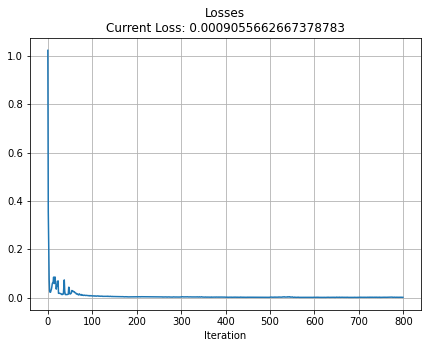

In [0]:
losses = []
avg_grad_logs = []
val_losses = []
best_val_loss = 1
loss = 'null'

data_loader = train_loader

torch.cuda.empty_cache()


for i in range(EPOCHS):
  for i, batch in enumerate(data_loader):
      clean_images, gt = batch
      noise=torch.distributions.poisson.Poisson(clean_images.detach()).sample()*NOISE_WEIGHT
      #gaussian=torch.randn(clean_images.size())*NOISE_WEIGHT/15
      noisy_images=clean_images+noise
      clean_images=clean_images.to(device)
      eta = torch.zeros(noisy_images.shape).to(device)

      optimizer.zero_grad()
      model.zero_grad()
      
      eta, hx = model.forward(eta,noisy_images,n_steps=MAX_T)



      loss = torch.nn.functional.mse_loss(eta[0,0], clean_images[0,0])

      eta=eta.detach()


      loss.backward()


      optimizer.step()

      losses.append(loss.item())

      live_plot(losses,title="Losses\nCurrent Loss: "+str(loss.item()))

In [0]:
from skimage.measure import compare_psnr
model.eval()
best_images=[]
best_images_labels=[]
best_loss=1
snrs=[]
ssim=[]

for i, batch in enumerate(validation_loader):

    with torch.no_grad():
      clean_images, gt = batch
      noise=torch.distributions.poisson.Poisson(clean_images.detach()).sample()*NOISE_WEIGHT
      #gaussian=torch.randn(clean_images.size())*NOISE_WEIGHT/15
      noisy_images=clean_images+noise


      eta = torch.zeros(noisy_images.shape).to(device)


      output, hx = model.forward(eta, noisy_images,n_steps=MAX_T)
      output=output.cpu()
      loss = torch.nn.functional.mse_loss(output[0,0], clean_images[0,0])
      loss_noisy = torch.nn.functional.mse_loss(noisy_images[0,0], clean_images[0,0])

      if loss<best_loss:
        denoised=torch.clamp(output[0,0],0,1)
        best_images.append([noisy_images[0,0],denoised,clean_images[0,0]])

        noisy_np=noisy_images[0,0].detach().cpu().numpy()
        denoised_np=denoised.detach().cpu().numpy()
        clean_np=clean_images[0,0].detach().cpu().numpy()

        ssm_base=round(ssm(clean_np,clean_np),2)
        ssm_denoised=round(ssm(clean_np,denoised_np),2)
        ssm_noisy=round(ssm(clean_np,noisy_np),2)

        PSNR_base=round(compare_psnr(clean_np,clean_np),2)
        PSNR_denoised=round(compare_psnr(clean_np,denoised_np),2)
        PSNR_noisy=round(compare_psnr(clean_np,noisy_np),2)

        input_label="Input\nSSIM: " + str(ssm_noisy) + "\nPSNR: " + str(PSNR_noisy)
        denoised_label="Denoised\nSSIM: " + str(ssm_denoised) + "\nPSNR: " + str(PSNR_denoised)
        base_label="Ground Truth\nSSIM: " + str(ssm_base) + "\nPSNR: " + str(PSNR_base)

        best_images_labels.append([input_label,denoised_label,base_label])
        snrs.append(PSNR_denoised)
        ssim.append(ssm_denoised)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version

Average SSIM: 0.9018
Average PSNR: 31.612599999999997


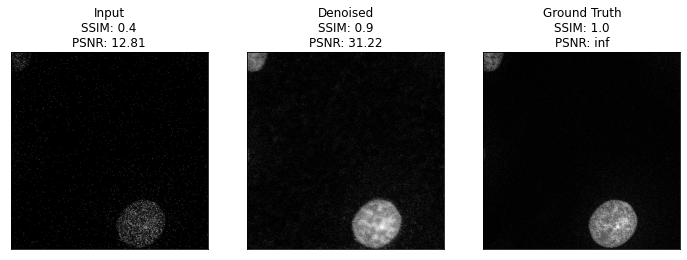

In [0]:
idx=len(best_images)-5
a=plot_tensors(best_images[idx],best_images_labels[idx])
print("Average SSIM: "+ str(np.mean(ssim)) + "\nAverage PSNR: " + str(np.mean(snrs)))